## Random assignment, binary CATE example

This is a fully worked-out notebook showing how you would apply auto-causality to a dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now.. 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy, auto-causality, and FLAML from source
root_path = root_path = os.path.realpath('../..')
try: 
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))
    
try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))
    
try:
    import flaml
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "FLAML"))
    

In [2]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from auto_causality import AutoCausality
from auto_causality.datasets import synth_ihdp
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import ate, group_ate

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the normalized ERUPT metric (chosen to specifically look for differences in impact across customers) on held-out data.

We import an example dataset and pre-process it. The pre-processing fills in the NaNs and one-hot-encodes all categorical and int variables.

If you don't want an int variable to be one-hot-encoded, please cast it to float before preprocessing.

In [5]:
data = synth_ihdp()
treatment = data.treatment
targets = data.outcomes
data_df, features_X, features_W = preprocess_dataset(data.data, treatment, targets)

outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)

Fitting the model is as simple as calling AutoCausality.fit(), with the only required parameter apart from the data being the amount of time you want to give the optimizer, either for the whole run (`time_budget`) or per FLAML component model (`components_time_budget`), or both.

If you want to use specific estimators, comment in the `estimator_list` below to include any estimators whose full name contains any of the elements of `estimator_list`.

The other allowed values are `all` and `auto`, the default is `auto`.


In [6]:
ac = AutoCausality(
#     time_budget=120, 
#     estimator_list=[
#             "Dummy",
#             "SparseLinearDML",
#             "ForestDRLearner",
#             "TransformedOutcome",
#             "CausalForestDML",
#             ".LinearDML",
#             "DomainAdaptationLearner",
#             "SLearner",
#             "XLearner",
#             "TLearner",
#             "Ortho",
#         ],
    metric="norm_erupt", 
    verbose=3,
    components_verbose=2,
    components_time_budget=300,
)


# run autocausality
ac.fit(train_df, treatment, outcome, features_W, features_X)

# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")


[I 2022-06-21 12:01:26,177] A new study created in memory with name: optuna
[flaml.tune.tune: 06-21 12:01:26] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}, {'estimator': {'estimat

[flaml.tune.tune: 06-21 12:01:54] {118} INFO - result: {'norm_erupt': 2.215146974286003, 'estimator_name': 'backdoor.auto_causality.models.Dummy', 'scores': {'train': {'erupt': 6.383571274578571, 'norm_erupt': 2.592427000014072, 'qini': 0.014437432375275651, 'auc': 0.5268144166649252, 'ate': 3.908720992971213, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D76C28FB50>, 'values':      treated  y_factual         p  policy  norm_policy  weights
0        0.0   2.440818  0.201258    True        False  0.00000
1        0.0   4.794640  0.201258    True         True  0.00000
2        0.0   0.287976  0.201258    True         True  0.00000
3        1.0   6.205641  0.201258    True         True  4.96875
4        1.0   6.612036  0.201258    True         True  4.96875
..       ...        ...       ...     ...          ...      ...
472      0.0   2.577294  0.201258    True        False  0.00000
473      1.0   7.331501  0.201258    True        False  4.968

{'estimator_name': 'backdoor.econml.metalearners.SLearner'}


[flaml.tune.tune: 06-21 12:07:21] {118} INFO - result: {'norm_erupt': 2.3062551700510046, 'estimator_name': 'backdoor.econml.metalearners.SLearner', 'scores': {'train': {'erupt': 6.395715136736222, 'norm_erupt': 2.8854984334346505, 'qini': 0.10347889563118054, 'auc': 0.5757603541111453, 'ate': 3.6208514064589536, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D76C84C700>, 'values':      treated  y_factual         p  policy  norm_policy   weights
0        0.0   2.440818  0.201258    True         True  0.000000
1        0.0   4.794640  0.201258    True        False  0.000000
2        0.0   0.287976  0.201258    True         True  0.000000
3        1.0   6.205641  0.201258    True         True  4.981416
4        1.0   6.612036  0.201258    True         True  4.981416
..       ...        ...       ...     ...          ...       ...
472      0.0   2.577294  0.201258    True         True  0.000000
473      1.0   7.331501  0.201258    True         

{'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}


[flaml.tune.tune: 06-21 12:22:23] {118} INFO - result: {'norm_erupt': 2.4074487693999913, 'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner', 'scores': {'train': {'erupt': 6.404294628707557, 'norm_erupt': 2.9342409282465187, 'qini': 0.09948859763342668, 'auc': 0.5885028809359255, 'ate': 3.906950472598306, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D774AF2AF0>, 'values':      treated  y_factual         p  policy  norm_policy   weights
0        0.0   2.440818  0.201258    True         True  0.000000
1        0.0   4.794640  0.201258    True        False  0.000000
2        0.0   0.287976  0.201258    True         True  0.000000
3        1.0   6.205641  0.201258    True         True  4.879108
4        1.0   6.612036  0.201258    True         True  4.879108
..       ...        ...       ...     ...          ...       ...
472      0.0   2.577294  0.201258    True         True  0.000000
473      1.0   7.331501  0.201258   

{'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}


[flaml.tune.tune: 06-21 12:32:24] {118} INFO - result: {'norm_erupt': 2.203795898827005, 'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'scores': {'train': {'erupt': 6.383571274578571, 'norm_erupt': 2.9553318408663904, 'qini': 0.12513767430304804, 'auc': 0.5821223045204225, 'ate': 3.940099024026429, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D7753CBFD0>, 'values':      treated  y_factual         p  policy  norm_policy  weights
0        0.0   2.440818  0.201258    True         True  0.00000
1        0.0   4.794640  0.201258    True        False  0.00000
2        0.0   0.287976  0.201258    True         True  0.00000
3        1.0   6.205641  0.201258    True         True  4.96875
4        1.0   6.612036  0.201258    True         True  4.96875
..       ...        ...       ...     ...          ...      ...
472      0.0   2.577294  0.201258    True         True  0.00000
473      1.0   7.331501  0.201258    True         True  4.96875

{'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}


[flaml.tune.tune: 06-21 12:42:26] {118} INFO - result: {'norm_erupt': 2.713717056387058, 'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'scores': {'train': {'erupt': 6.383571274578571, 'norm_erupt': 2.940601619855183, 'qini': 0.16498622125920806, 'auc': 0.580987117910112, 'ate': 3.830522708517715, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D775B9AA30>, 'values':      treated  y_factual         p  policy  norm_policy  weights
0        0.0   2.440818  0.201258    True         True  0.00000
1        0.0   4.794640  0.201258    True        False  0.00000
2        0.0   0.287976  0.201258    True         True  0.00000
3        1.0   6.205641  0.201258    True        False  4.96875
4        1.0   6.612036  0.201258    True         True  4.96875
..       ...        ...       ...     ...          ...      ...
472      0.0   2.577294  0.201258    True         True  0.00000
473      1.0   7.331501  0.201258    True         True  4.96875


{'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome'}


[flaml.tune.tune: 06-21 12:47:28] {118} INFO - result: {'norm_erupt': 2.651803367859286, 'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome', 'scores': {'train': {'erupt': 5.920690277306311, 'norm_erupt': 2.8726446415015845, 'qini': 0.2030398742779208, 'auc': 0.5232820957126672, 'ate': 3.6581633, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D7757BDA00>, 'values':      treated  y_factual         p  policy  norm_policy   weights
0        0.0   2.440818  0.201258    True         True  0.000000
1        0.0   4.794640  0.201258    True        False  0.000000
2        0.0   0.287976  0.201258    True        False  0.000000
3        1.0   6.205641  0.201258    True        False  4.391374
4        1.0   6.612036  0.201258    True        False  4.391374
..       ...        ...       ...     ...          ...       ...
472      0.0   2.577294  0.201258    True        False  0.000000
473      1.0   7.331501  0.201258    True        

{'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 0.0017231790528715186, 'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.18432972513405987, 'max_features': 'log2', 'min_impurity_decrease': 2.6639242043080236, 'max_samples': 0.378105341302808, 'min_balancedness_tol': 0.006805783323944936, 'honest': 1, 'subforest_size': 8}


[flaml.tune.tune: 06-21 12:57:31] {118} INFO - result: {'norm_erupt': 2.3255334980227014, 'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'scores': {'train': {'erupt': 6.383571274578571, 'norm_erupt': 2.470994880848279, 'qini': -0.030764007642303127, 'auc': 0.5044174054106755, 'ate': 3.7977801274398, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D7766FC880>, 'values':      treated  y_factual         p  policy  norm_policy  weights
0        0.0   2.440818  0.201258    True        False  0.00000
1        0.0   4.794640  0.201258    True        False  0.00000
2        0.0   0.287976  0.201258    True        False  0.00000
3        1.0   6.205641  0.201258    True        False  4.96875
4        1.0   6.612036  0.201258    True        False  4.96875
..       ...        ...       ...     ...          ...      ...
472      0.0   2.577294  0.201258    True        False  0.00000
473      1.0   7.331501  0.201258    True        False  4.96875

{'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 144, 'criterion': 'het', 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'min_impurity_decrease': 1.588829994148435, 'max_samples': 0.2725025036887243, 'min_balancedness_tol': 0.48754359233669453, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 5}


[flaml.tune.tune: 06-21 13:07:33] {118} INFO - result: {'norm_erupt': 2.3255334980227014, 'estimator': <dowhy.causal_estimator.CausalEstimate object at 0x000001D7759900D0>, 'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'scores': {'train': {'erupt': 6.383571274578571, 'norm_erupt': 2.798918797287757, 'qini': 0.06844491128235182, 'auc': 0.5521118871183965, 'ate': 3.919283763881301, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D7779B59A0>, 'values':      treated  y_factual         p  policy  norm_policy  weights
0        0.0   2.440818  0.201258    True         True  0.00000
1        0.0   4.794640  0.201258    True        False  0.00000
2        0.0   0.287976  0.201258    True         True  0.00000
3        1.0   6.205641  0.201258    True         True  4.96875
4        1.0   6.612036  0.201258    True         True  4.96875
..       ...        ...       ...     ...          ...      ...
472      0.0   2.577294  0.201258    True  

{'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 148, 'criterion': 'het', 'min_samples_split': 21, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 10, 'max_samples': 1, 'min_balancedness_tol': 0.0, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 8}


[flaml.tune.tune: 06-21 13:17:36] {118} INFO - result: {'norm_erupt': 2.3255334980227014, 'estimator': <dowhy.causal_estimator.CausalEstimate object at 0x000001D76CA4AF40>, 'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'scores': {'train': {'erupt': 6.383571274578571, 'norm_erupt': 2.470994880848279, 'qini': -0.030764007642303127, 'auc': 0.5044174054106755, 'ate': 3.752038193804248, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x000001D77800D7F0>, 'values':      treated  y_factual         p  policy  norm_policy  weights
0        0.0   2.440818  0.201258    True        False  0.00000
1        0.0   4.794640  0.201258    True        False  0.00000
2        0.0   0.287976  0.201258    True        False  0.00000
3        1.0   6.205641  0.201258    True        False  4.96875
4        1.0   6.612036  0.201258    True        False  4.96875
..       ...        ...       ...     ...          ...      ...
472      0.0   2.577294  0.201258    True

Best estimator: backdoor.econml.dml.CausalForestDML
best config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}}
best score: 2.713717056387058


After running a fit, you can resume it without losing past results, for example if you want to search over extra estimators.

In [7]:
# we can now resume the fit to continue with the init_cfgs which we haven't tried yet
# ac.fit(train_df, treatment, outcome, features_W, features_X,resume=True)
# # return best estimator
# print(f"Best estimator: {ac.best_estimator}")
# # config of best estimator:
# print(f"best config: {ac.best_config}")
# # best score:
# print(f"best score: {ac.best_score}")

In [8]:
# ac.results.results

In [9]:
# score all estimators on the test set, which we've kept aside up till now
from auto_causality.scoring import make_scores
for est_name, scr in ac.scores.items():
    scr['scores']['test'] = make_scores(scr['estimator'], test_df, ac.propensity_model)

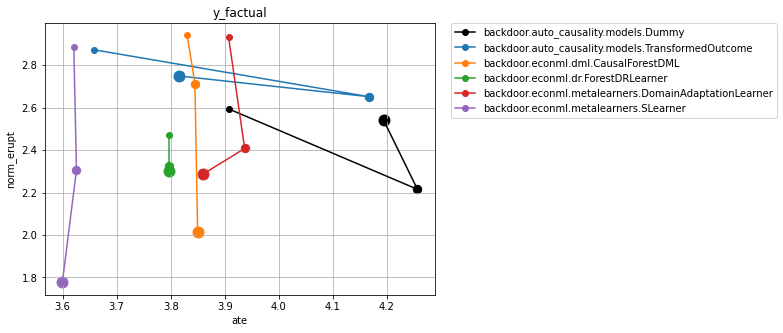

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "ate"
m2 = "norm_erupt"

for (est, scr), col in zip(ac.scores.items(),colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        crv = [scr["scores"]['train'][m2], scr["scores"]['validation'][m2], scr["scores"]['test'][m2]]
        plt.plot(sc, crv, color=col, marker="o", label=est)
        plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
        plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

    except:
        pass
plt.xlabel(m1)
plt.ylabel(m2)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


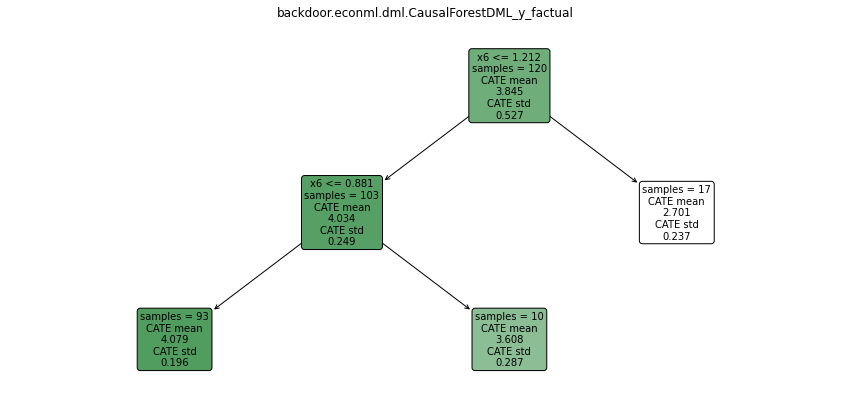

In [11]:
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()


y_factual backdoor.econml.dml.CausalForestDML


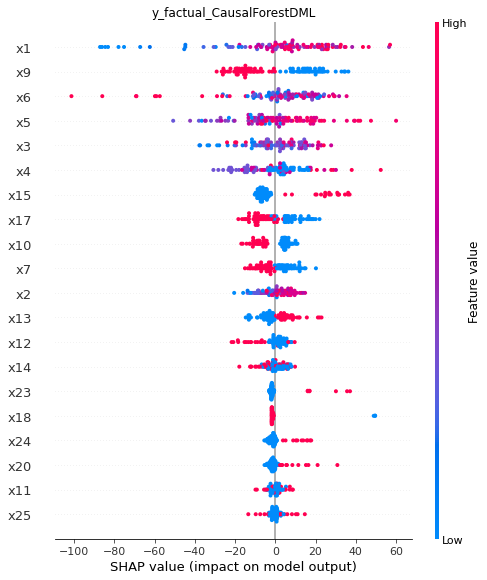

In [12]:
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

scr = ac.scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()


,policy,mean,std,count
0,all,4.196312,0.300749,150
1,False,4.112514,0.350813,115
2,True,4.454203,0.477607,35


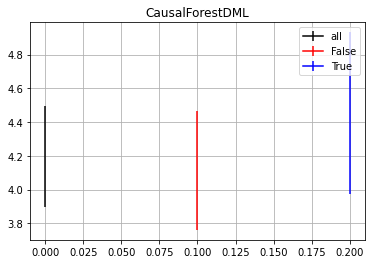

In [13]:
from auto_causality.scoring import  group_ate
# plot out-of sample difference of outcomes between treated and untreated for the points where a model predicts positive vs negative impact
my_est = ac.best_estimator
stats = []

v = ac.scores[my_est]['scores']['test']['values']

sts = group_ate(v['treated'], v[outcome], v['norm_policy'])

display(sts)


colors = (matplotlib.colors.CSS4_COLORS['black'],
    matplotlib.colors.CSS4_COLORS['red'],
    matplotlib.colors.CSS4_COLORS['blue'])

grp = sts["policy"].unique()

for i,(p,c) in enumerate(zip(grp, colors)):
    st = sts[sts["policy"] == p]
    plt.errorbar(np.array(range(len(st))) +0.1*i, st["mean"].values[0],  yerr = st["std"].values[0], color=c)
plt.legend(grp)
plt.grid(True)
plt.title(my_est.split('.')[-1])
plt.show()